# KNN Murni - Stress Level Detection

Implementasi KNN dasar tanpa optimasi tambahan untuk klasifikasi tingkat stress.

In [58]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
  Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


## 1. Data Loading dan Preprocessing

In [60]:
FILE_PATH = './dataset/fix dataset 1031.csv'

# Read CSV with semicolon as separator and handle mixed decimal separators
df = pd.read_csv(FILE_PATH, sep=';', decimal='.')
dataset = df.copy()

# Tampilkan Semua row pada kolom pertama yang memiliki nilai NaN
print("📊 DATASET INFORMATION:")
print("Jumlah baris yang memiliki nilai NaN pada kolom pertama:", dataset[dataset.columns[0]].isna().sum())

# Bersihkan data dengan menghapus baris yang memiliki nilai NaN pada kolom pertama
dataset = dataset.dropna(subset=[dataset.columns[0]])

print("Dataset shape:", dataset.shape)
display(dataset.head())

📊 DATASET INFORMATION:
Jumlah baris yang memiliki nilai NaN pada kolom pertama: 65
Dataset shape: (1031, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126/83,77.0,4200.0,NaN
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea


In [61]:
# Check for missing values
print("Missing values per column:")
nan_counts = dataset.isna().sum()
display(nan_counts[nan_counts > 0])

Missing values per column:


Sleep Disorder    438
dtype: int64

In [62]:
# Fill missing values in Sleep Disorder with 'Normal'
dataset['Sleep Disorder'] = dataset['Sleep Disorder'].fillna('Normal')

# Split Blood Pressure column
if 'Blood Pressure' in dataset.columns:
    dataset[['Systolic', 'Diastolic']] = dataset['Blood Pressure'].str.split('/', expand=True)
    dataset['Systolic'] = pd.to_numeric(dataset['Systolic'], errors='coerce')
    dataset['Diastolic'] = pd.to_numeric(dataset['Diastolic'], errors='coerce')
    dataset = dataset.drop('Blood Pressure', axis=1)

# Clean numeric columns
kolom_numerik = ["Sleep Duration", "Heart Rate", "Daily Steps", "Systolic", "Diastolic"]
for col in kolom_numerik:
    if col in dataset.columns:
        dataset[col] = dataset[col].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

print("✅ Data preprocessing selesai")
display(dataset.head())

✅ Data preprocessing selesai


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1.0,Male,27.0,Software Engineer,6.01,6.0,42.0,6.0,Overweight,77.0,4200.0,Normal,126,83
1,2.0,Male,28.0,Doctor,6.02,6.0,60.0,8.0,Normal,75.0,10000.0,Normal,125,80
2,3.0,Male,28.0,Doctor,6.02,6.0,60.0,8.0,Normal,75.0,10000.0,Normal,125,80
3,4.0,Male,28.0,Sales Representative,5.09,4.0,30.0,8.0,Obese,85.0,3000.0,Sleep Apnea,140,90
4,5.0,Male,28.0,Sales Representative,5.09,4.0,30.0,8.0,Obese,85.0,3000.0,Sleep Apnea,140,90


## 2. Target Encoding dan Feature Selection

Target classes: ['Insomnia' 'Normal' 'Sleep Apnea']
Encoded values: [0 1 2]

=== DISTRIBUSI KELAS ORIGINAL ====
Insomnia: 296 samples
Normal: 438 samples
Sleep Apnea: 297 samples


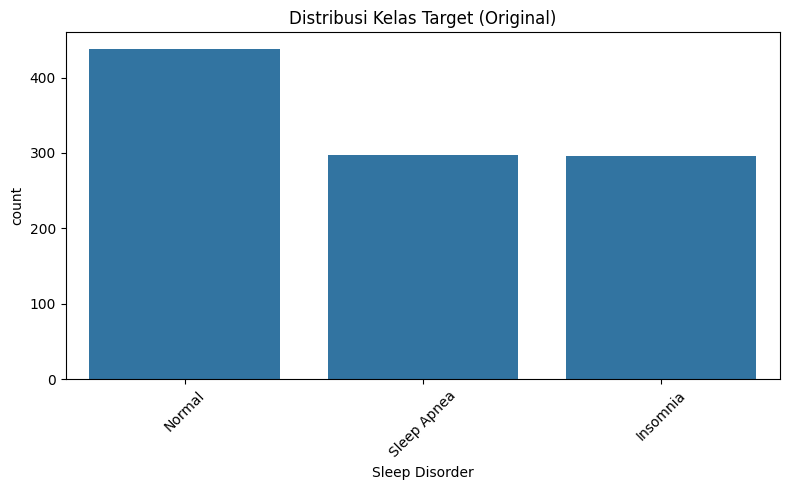

In [63]:
# Label encoding for target
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(dataset['Sleep Disorder'])

print("Target classes:", label_encoder.classes_)
print("Encoded values:", np.unique(target_encoded))

# Show class distribution
print("\n=== DISTRIBUSI KELAS ORIGINAL ====")
class_counts = pd.Series(target_encoded).value_counts().sort_index()
for i, count in enumerate(class_counts):
    print(f"{label_encoder.classes_[i]}: {count} samples")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='Sleep Disorder')
plt.title('Distribusi Kelas Target (Original)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
# Select features
feature_columns = ["Gender", "Age", "Occupation", "Sleep Duration", "Quality of Sleep", 
                  "Physical Activity Level", "Stress Level", "BMI Category", "Systolic", "Diastolic"]

# Filter only existing columns
available_features = [col for col in feature_columns if col in dataset.columns]
features = dataset[available_features]

print("Selected features:", available_features)
print("Features shape:", features.shape)
display(features.head())

Selected features: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Systolic', 'Diastolic']
Features shape: (1031, 10)


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic,Diastolic
0,Male,27.0,Software Engineer,6.01,6.0,42.0,6.0,Overweight,126,83
1,Male,28.0,Doctor,6.02,6.0,60.0,8.0,Normal,125,80
2,Male,28.0,Doctor,6.02,6.0,60.0,8.0,Normal,125,80
3,Male,28.0,Sales Representative,5.09,4.0,30.0,8.0,Obese,140,90
4,Male,28.0,Sales Representative,5.09,4.0,30.0,8.0,Obese,140,90


## 3. Data Splitting

In [65]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

print("=== DATA SPLIT ====")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print("\nDistribusi y_train:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist):
    print(f"{label_encoder.classes_[i]}: {count} samples")

print("\nDistribusi y_test:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for i, count in enumerate(test_dist):
    print(f"{label_encoder.classes_[i]}: {count} samples")

=== DATA SPLIT ====
Training set: 824 samples
Test set: 207 samples

Distribusi y_train:
Insomnia: 237 samples
Normal: 350 samples
Sleep Apnea: 237 samples

Distribusi y_test:
Insomnia: 59 samples
Normal: 88 samples
Sleep Apnea: 60 samples


## 4. Pipeline Setup

In [66]:
# Define numerical and categorical features
numerical_features = [col for col in available_features if features[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in available_features if features[col].dtype == 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

print("✅ Preprocessor pipeline created")

Numerical features: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Systolic', 'Diastolic']
Categorical features: ['Gender', 'Occupation', 'BMI Category']
✅ Preprocessor pipeline created


## 5. KNN Murni Training

In [67]:
# Create KNN pipeline with default parameters (k=5)
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Train the model
print("Training KNN model...")
knn_pipeline.fit(X_train, y_train)
print("✅ Model training completed")

Training KNN model...
✅ Model training completed


## 6. Model Evaluation

In [68]:
# Make predictions
y_pred = knn_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("=== HASIL EVALUASI KNN MURNI ====")
print(f"Akurasi: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

=== HASIL EVALUASI KNN MURNI ====
Akurasi: 0.8889 (88.89%)

Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.82      0.90      0.85        59
      Normal       0.91      0.89      0.90        88
 Sleep Apnea       0.95      0.88      0.91        60

    accuracy                           0.89       207
   macro avg       0.89      0.89      0.89       207
weighted avg       0.89      0.89      0.89       207



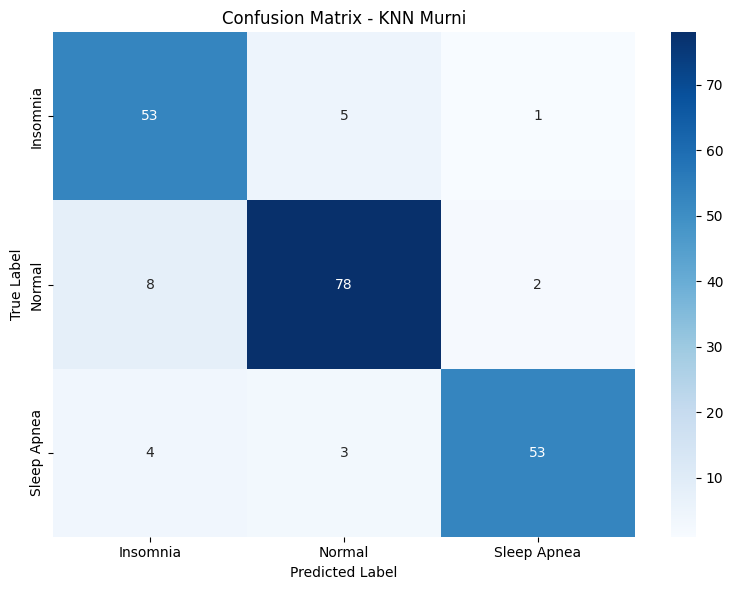

In [69]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - KNN Murni")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 7. Testing Different K Values

In [70]:
# Test different k values
k_values = range(1, 21)
accuracies = []

print("Testing different k values...")
for k in k_values:
    knn_pipeline.set_params(knn__n_neighbors=k)
    knn_pipeline.fit(X_train, y_train)
    y_pred_k = knn_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)
    print(f"k={k}: Accuracy = {acc:.4f}")

# Find best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

print(f"\n=== BEST K VALUE ====")
print(f"Best k: {best_k}")
print(f"Best accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

Testing different k values...
k=1: Accuracy = 0.7874
k=2: Accuracy = 0.7826
k=3: Accuracy = 0.8502
k=4: Accuracy = 0.8792
k=5: Accuracy = 0.8889
k=6: Accuracy = 0.9130
k=7: Accuracy = 0.9082
k=8: Accuracy = 0.9130
k=9: Accuracy = 0.9082
k=10: Accuracy = 0.9130
k=11: Accuracy = 0.9082
k=12: Accuracy = 0.9034
k=13: Accuracy = 0.8986
k=14: Accuracy = 0.9034
k=15: Accuracy = 0.8986
k=16: Accuracy = 0.8986
k=17: Accuracy = 0.8986
k=18: Accuracy = 0.8889
k=19: Accuracy = 0.8696
k=20: Accuracy = 0.8696

=== BEST K VALUE ====
Best k: 6
Best accuracy: 0.9130 (91.30%)


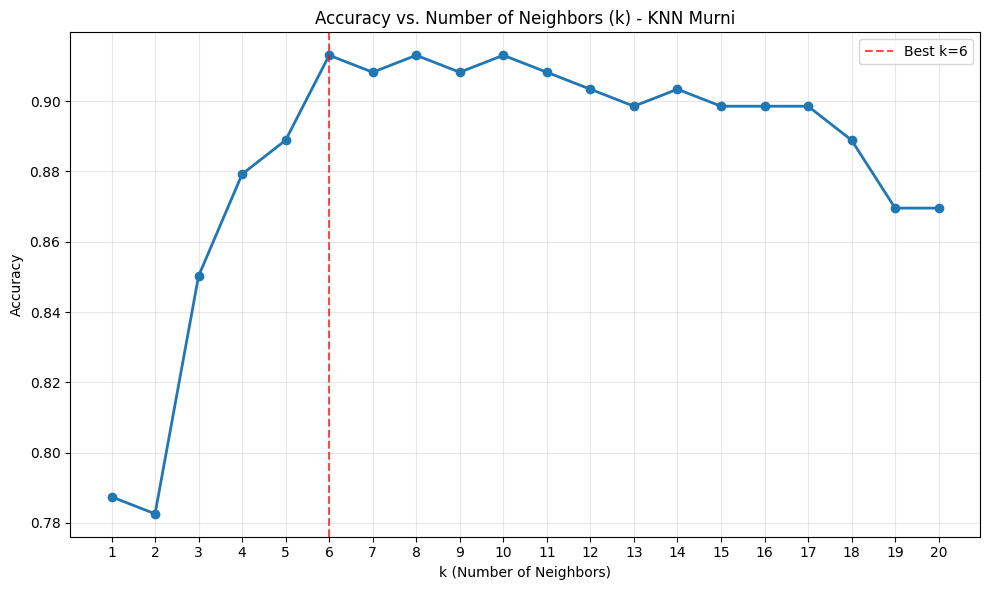

In [71]:
# Plot accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linewidth=2, markersize=6)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
plt.title('Accuracy vs. Number of Neighbors (k) - KNN Murni')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()

## 8. Final Model dengan Best K

In [72]:
# Train final model with best k
final_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

final_knn.fit(X_train, y_train)
final_pred = final_knn.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)

print("=== FINAL MODEL PERFORMANCE ====")
print(f"Final model dengan k={best_k}")
print(f"Final accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print("\nFinal Classification Report:")
print(classification_report(y_test, final_pred, target_names=label_encoder.classes_))

=== FINAL MODEL PERFORMANCE ====
Final model dengan k=6
Final accuracy: 0.8889 (88.89%)

Final Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.82      0.90      0.85        59
      Normal       0.91      0.89      0.90        88
 Sleep Apnea       0.95      0.88      0.91        60

    accuracy                           0.89       207
   macro avg       0.89      0.89      0.89       207
weighted avg       0.89      0.89      0.89       207



## Summary

**KNN Murni Results:**
- Dataset menggunakan data asli tanpa balancing
- Best k value yang ditemukan melalui testing manual
- Akurasi final model dengan hyperparameter terbaik

In [73]:
# pip install --upgrade imbalanced-learn

In [74]:
# pip install pandas matplotlib seaborn

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
import pandas as pd

FILE_PATH = './dataset/fix dataset 1031.csv'

# Membaca file CSV dengan delimiter ';'
df = pd.read_csv(FILE_PATH, delimiter=';')
dataset = df.copy()

# Menampilkan judul
print("Dataset Original")
print("==================================")

# Menampilkan tabel dengan format rapi
display(dataset.head())  # jika menggunakan Jupyter/Colab


Dataset Original


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126/83,77.0,4200.0,NaN
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea


In [77]:
# Menampilkan jumlah data NaN per kolom dalam bentuk tabel
nan_count = df.isna().sum()
nan_count_df = nan_count.reset_index()
nan_count_df.columns = ['Kolom', 'Jumlah NaN']
print("Jumlah data NaN per kolom:")
display(nan_count_df)

# Menampilkan hanya kolom yang memiliki NaN
nan_only = df[df.columns[df.isna().any()]].isna().sum()
nan_only_df = nan_only.reset_index()
nan_only_df.columns = ['Kolom', 'Jumlah NaN']
print("Kolom yang memiliki nilai NaN:")
display(nan_only_df)

Jumlah data NaN per kolom:


,Kolom,Jumlah NaN
0,Person ID,65
1,Gender,65
2,Age,65
3,Occupation,65
4,Sleep Duration,65
5,Quality of Sleep,65
6,Physical Activity Level,65
7,Stress Level,65
8,BMI Category,65
9,Blood Pressure,65


Kolom yang memiliki nilai NaN:


,Kolom,Jumlah NaN
0,Person ID,65
1,Gender,65
2,Age,65
3,Occupation,65
4,Sleep Duration,65
5,Quality of Sleep,65
6,Physical Activity Level,65
7,Stress Level,65
8,BMI Category,65
9,Blood Pressure,65


In [78]:
# Ganti Label NaN ke Normal
print("Step 1: Mengisi kolom yang NaN menjadi Kategori Normal")
print("==================================")
dataset["Sleep Disorder"] = dataset["Sleep Disorder"].fillna("Normal")
display(dataset.head())


Step 1: Mengisi kolom yang NaN menjadi Kategori Normal


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126/83,77.0,4200.0,Normal
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,Normal
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,Normal
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea


In [79]:
# Label Encoding untuk target
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(dataset["Sleep Disorder"])

In [80]:
# Label encoding
print("\n--- Sebelum Encoding Target ---")

# Define the 'target' variable here
target = dataset["Sleep Disorder"] # Assign the original target column

print("Tipe data target:", target.dtype)
print("Nilai unik target:", target.unique())

#label_encoder = LabelEncoder() # This line is commented out, which is fine as it was already initialized
#target_encoded = label_encoder.fit_transform(target) # This line is also commented out, which is fine as target_encoded was created in the previous cell

print("\n--- Setelah Encoding Target ---")
# Ensure target_encoded exists before using it. It is created in the previous cell.
print("Tipe data target (setelah encoding):", target_encoded.dtype)
print("Nilai unik target (setelah encoding):", pd.Series(target_encoded).unique())
print("Mapping LabelEncoder:", list(label_encoder.classes_), "->", list(range(len(label_encoder.classes_))))


--- Sebelum Encoding Target ---
Tipe data target: object
Nilai unik target: ['Normal' 'Sleep Apnea' 'Insomnia']

--- Setelah Encoding Target ---
Tipe data target (setelah encoding): int64
Nilai unik target (setelah encoding): [1 2 0]
Mapping LabelEncoder: ['Insomnia', 'Normal', 'Sleep Apnea'] -> [0, 1, 2]


In [81]:
from IPython.display import display
import pandas as pd # Pastikan pandas diimpor jika cell ini dijalankan secara terpisah

# Memisahkan kolom 'Blood Pressure'
if 'Blood Pressure' in dataset.columns:
    dataset[['Systolic', 'Diastolic']] = dataset['Blood Pressure'].str.split('/', expand=True)
    dataset['Systolic'] = pd.to_numeric(dataset['Systolic'], errors='coerce')
    dataset['Diastolic'] = pd.to_numeric(dataset['Diastolic'], errors='coerce')
    # Hapus kolom 'blood pressure' yang asli jika sudah tidak diperlukan
    dataset = dataset.drop('Blood Pressure', axis=1)

    # Tampilkan dengan format tabel
    print("Dataset setelah memisahkan 'Blood Pressure':")
    print("=============================================")
    display(dataset.head())
else:
    print("'Blood Pressure' column not found in the dataset. It might have been processed already.")
    # You might want to display the current dataset head here as well
    display(dataset.head())


Dataset setelah memisahkan 'Blood Pressure':


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,77.0,4200.0,Normal,126.0,83.0
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,75.0,10000.0,Normal,125.0,80.0
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,75.0,10000.0,Normal,125.0,80.0
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,85.0,3000.0,Sleep Apnea,140.0,90.0
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,85.0,3000.0,Sleep Apnea,140.0,90.0


In [82]:
# *** Move the data cleaning code here ***
# Daftar kolom numerik yang perlu dibersihkan dari koma
kolom_numerik = ["Sleep Duration", "Heart Rate", "Daily Steps", "Systolic", "Diastolic"] # Added Systolic and Diastolic assuming they might have commas initially before split


In [83]:
# Memisahkan fitur dan target
features = dataset[["Gender", "Age", "Occupation", "Sleep Duration",
                     "Quality of Sleep", "Physical Activity Level",
                     "Stress Level", "BMI Category", "Systolic", "Diastolic"]]
target = dataset["Sleep Disorder"]

print("\nStep 2: Memisahkan fitur dan target")
print("==================================")
print("Features (head):")
display(features.head(7))
print("\nTarget (head):")
display(target.head(7))



Step 2: Memisahkan fitur dan target
Features (head):


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic,Diastolic
0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126.0,83.0
1,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125.0,80.0
2,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125.0,80.0
3,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140.0,90.0
4,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140.0,90.0
5,Male,28.0,Software Engineer,05.09,4.0,30.0,8.0,Obese,140.0,90.0
6,Male,29.0,Teacher,06.03,6.0,40.0,7.0,Obese,140.0,90.0



Target (head):


0         Normal
1         Normal
2         Normal
3    Sleep Apnea
4    Sleep Apnea
5       Insomnia
6       Insomnia
Name: Sleep Disorder, dtype: object

In [84]:
numerical_column = 'Physical Activity Level' # Example: Replace with the actual numerical column name

# Check if the column is numeric before proceeding
if pd.api.types.is_numeric_dtype(df[numerical_column]):
    Q1 = df[numerical_column].quantile(0.25)
    Q3 = df[numerical_column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cari baris yang merupakan outlier
    outliers = df[(df[numerical_column] < lower_bound) | (df[numerical_column] > upper_bound)]

    print(f"Jumlah outlier pada kolom '{numerical_column}': {len(outliers)}")
    print(outliers)
else:
    print(f"Kolom '{numerical_column}' tidak bersifat numerik. Tidak dapat menghitung outlier menggunakan metode IQR.")

Jumlah outlier pada kolom 'Physical Activity Level': 0
Empty DataFrame
Columns: [Person ID, Gender, Age, Occupation, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, BMI Category, Blood Pressure, Heart Rate, Daily Steps, Sleep Disorder]
Index: []


In [85]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

print("\n--- Data Latih dan Uji ---")
print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))

print("Distribusi y_train:")
display(pd.Series(y_train).value_counts())

print("\nDistribusi y_test:")
display(pd.Series(y_test).value_counts())


--- Data Latih dan Uji ---
Jumlah data latih: 876
Jumlah data uji: 220
Distribusi y_train:


1    400
0    240
2    236
Name: count, dtype: int64


Distribusi y_test:


1    103
2     61
0     56
Name: count, dtype: int64

In [86]:
# Mendefinisikan fitur numerik dan kategorikal
numerical_features = ["Age", "Sleep Duration", "Quality of Sleep",
                      "Physical Activity Level", "Stress Level","Systolic", "Diastolic"]
categorical_features = ["Gender", "Occupation", "BMI Category"]

#Mendefinisikan Preprocessor
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [87]:
display("Training Features (X_train):\n", X_train)
display("\nTraining Target (y_train):\n", y_train)

'Training Features (X_train):\n'

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic,Diastolic
2,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125.0,80.0
6,Male,29.0,Teacher,06.03,6.0,40.0,7.0,Obese,140.0,90.0
590,Male,42.0,Lawyer,7.8,8.0,90.0,5.0,Normal,130.0,85.0
634,Male,29.0,Doctor,6,6.0,30.0,8.0,Normal,120.0,80.0
842,Female,45.0,Teacher,6.5,7.0,45.0,4.0,Overweight,135.0,90.0
...,...,...,...,...,...,...,...,...,...,...
330,Female,53.0,Engineer,08.05,9.0,30.0,3.0,Normal,125.0,80.0
466,Female,52.0,Engineer,8.4,9.0,30.0,3.0,Normal,125.0,80.0
121,Female,37.0,Accountant,07.02,8.0,60.0,4.0,Normal,115.0,75.0
1044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'\nTraining Target (y_train):\n'

array([1, 0, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 1, 2, 2, 2, 2,
       0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2,
       1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 1, 2, 0, 2, 2, 2, 1, 0, 1,
       0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 1,
       2, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0,
       1, 2, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1,
       0, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0,
       2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1,
       1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1,